## 使用的算法分块解释和测试，并进行一些比较的报告  
                                by:吴宇森2000013137  

### 一、数据准备和预处理
为方便，用之前作业中的股价序列作为输入股价序列的模拟  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from random import randint, random, shuffle
from tqdm import trange

#读取数据
stock_data = pd.read_csv('Stock_Price.csv')  

print(stock_data)
print(adfuller(stock_data['TWTR']))

            Date       TWTR         KO         GM
0     2013-11-07  44.900002  30.350573  27.762348
1     2013-11-08  41.650002  30.518206  28.334280
2     2013-11-11  42.900002  30.381044  28.349743
3     2013-11-12  41.900002  30.388666  28.334280
4     2013-11-13  42.599998  30.571535  29.710032
...          ...        ...        ...        ...
2129  2022-04-25  51.700001  65.940002  39.820000
2130  2022-04-26  49.680000  65.050003  38.040001
2131  2022-04-27  48.639999  65.559998  38.660000
2132  2022-04-28  49.110001  66.190002  38.750000
2133  2022-04-29  49.020000  64.610001  37.910000

[2134 rows x 4 columns]
(-2.107265967482351, 0.24160297489559274, 15, 2118, {'1%': -3.433441238483705, '5%': -2.862905584504915, '10%': -2.567496971789981}, 7138.717165683749)


1.1差分法规整处理

In [2]:
data=pd.DataFrame(stock_data['TWTR'])

'''
差分法规整
'''
for i in range(0,1):
    data=data.diff(periods=7) 
#print(data)

'''
检查规整结果，第二个参数接近于0
'''
print(adfuller(data[7:]))
#print(data[5:])
data=data[5:]

(-9.156413259673016, 2.6025580161717963e-15, 23, 2103, {'1%': -3.4334633142611697, '5%': -2.862915331606178, '10%': -2.567502161536324}, 7510.054185356738)


1.2 卡尔曼滤波，对原始序列进行平滑

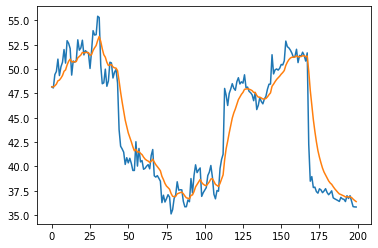

In [3]:
'''
卡尔曼滤波，对数据进行平滑
'''
kalman_data=pd.DataFrame(stock_data['TWTR'])
def Kalman_filter(x,P0=0.02,q=0.02,r=0.55):
    x_filter = x.copy()
    p_last = P0
    for i in range(1,x.shape[0]):
    	#协方差预测
        p_mid = p_last + q
        #卡尔曼参数
        k = p_mid / (p_mid + r)
        #状态估计
        x_filter[i] = x_filter[i-1] + k * (x[i] - x_filter[i-1])
        #噪声协方差更新
        p_last = (1 - k) * p_mid
    return x_filter
#print(kalman_data)
#print(Kalman_filter(np.array(kalman_data)))
#绘出平滑前后的效果
plt.plot([i for i in range(0,200)],kalman_data[200:400])
plt.plot(Kalman_filter(np.array(kalman_data[200:400])))
kalman_data=Kalman_filter(np.array(kalman_data[200:400]))

1.3 谱分析角度，用SVD进行主成分重构滤波

<AxesSubplot:>

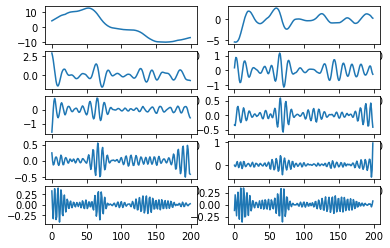

<Figure size 432x288 with 0 Axes>

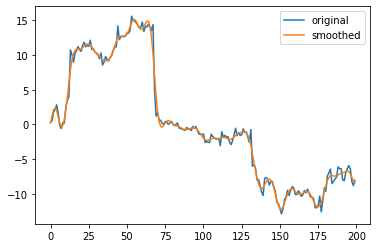

In [4]:
'''
谱分解提取主成分后重构滤波（实际上可以直接用主成分作为谱特征，用作第三部分极值点预测所用的特征数组
'''
import numpy as np
import matplotlib.pyplot as plt

series = np.array(stock_data['TWTR'])[300:500]
#中心化，如果需要可通过重新加上原来的series还原
series = series - np.mean(series) 

#分割序列
#窗口长度
window_size = 20              
#序列长度
series_size = len(series)     
K = series_size - window_size + 1
X = np.zeros((window_size, K))
for i in range(K):
    X[:, i] = series[i:i + window_size]

#SVD分解并按照影响力升序排序
U, kernel, Vt = np.linalg.svd(X, full_matrices=False)

for i in range(Vt.shape[0]):
    Vt[i, :] *= kernel[i]
A = Vt

# 利用得到的因子重构序列，得到各个因子对应的子成分序列
rec = np.zeros((window_size, series_size))
for i in range(window_size):
    for j in range(window_size-1):
        for m in range(j+1):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= (j+1)
    for j in range(window_size-1, series_size - window_size + 1):
        for m in range(window_size):
            rec[i, j] += A[i, j-m] * U[m, i]
        rec[i, j] /= window_size
    for j in range(series_size - window_size + 1, series_size):
        for m in range(j-series_size+window_size, window_size):
            rec[i, j] += A[i, j - m] * U[m, i]
        rec[i, j] /= (series_size - j)
        
#重构过程
rrr = np.sum(rec[0:5], axis=0)

plt.figure()
for i in range(10):
    ax = plt.subplot(5,2,i+1)
    ax.plot(rec[i, :])
comp=pd.DataFrame()
comp['original']=series
comp['smoothed']=rrr
plt.figure(2)
comp.plot()


### 二、预测算法 ARIMA，var和hwes
尝试优化减小了MSE，比较两种方法的效果

2.1 ARIMA 和 Kalman-ARIMA

100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


0.1381735430942675


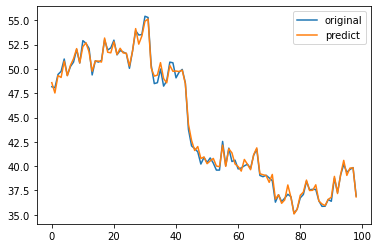

In [5]:
#直接使用ARIMA
data=pd.DataFrame(stock_data['TWTR'])
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import warnings 
from tqdm import tqdm
with warnings.catch_warnings(): #注意warning ignore必须放在这个with里面
    warnings.filterwarnings("ignore") 
    warnings.simplefilter('ignore')
    predict=[]
    for i in tqdm(range(200,300)):
        #训练
        tempModel = sm.tsa.arima.ARIMA(data[i-200:i],order=(7,0,4)).fit()
        #预测
        _next=tempModel.predict(200,202)
        predict.append(_next[i])
    tmp=[i for item in np.array(data[200:300].iloc[:,0:1]) for i in item]
    tmp=np.array(tmp)[:-1]
    predict=predict[1:]
    comp = pd.DataFrame()
    comp['original'] = tmp
    comp['predict'] =predict
    comp.plot()
    print(mean_squared_error(tmp,predict))

In [6]:
import statsmodels.api as sm
#svm和var算法
'''
找到合适的aic和bic order超参数
'''
#trend_evaluate = sm.tsa.arma_order_select_ic(data[:100], ic=['aic', 'bic'], trend='c', max_ar=6,max_ma=5)
#print('train AIC', trend_evaluate.aic_min_order)
#print('train BIC', trend_evaluate.bic_min_order)    

'''
进行ARIMA，取500到700项学习
'''
data=pd.DataFrame(stock_data['TWTR'])
data=Kalman_filter(np.array(data))
tempModel = sm.tsa.arima.ARIMA(data[500:700],order=(7,0,4)).fit()


D:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:>

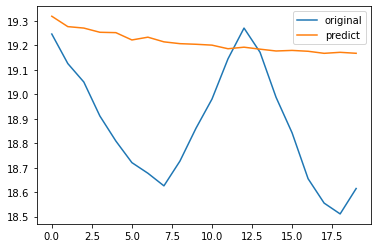

In [7]:
'''
预测紧接的20个结果，并和实际数据作图对比
'''
from sklearn.metrics import mean_squared_error
#print(data[5:])
#print(tempModel.predict(0,5))
data=pd.DataFrame(data)
tmp=[i for item in np.array(data[700:720].iloc[:,0:1]) for i in item]
#预测
predict=np.array(tempModel.predict(200,219))
comp = pd.DataFrame()
comp['original'] = tmp
comp['predict'] = predict
comp.plot()
#print(data[5:].iloc[:,0:1])
#print( tempModel.predict(0,1))
#print(data[0:2])
#可以看出五天内的趋势还是对的
#print(comp)


100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


0.09681712950881434


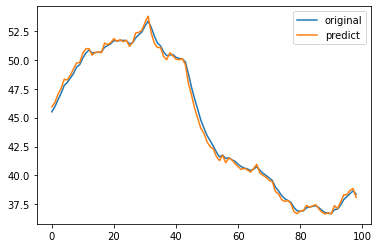

In [8]:
#放大一下预测范围,注意到ARIMA训练和预测还是比较久的，因为流程复杂
import warnings 
from tqdm import tqdm
with warnings.catch_warnings(): #注意warning ignore必须放在这个with里面
    warnings.filterwarnings("ignore") 
    warnings.simplefilter('ignore')
    predict=[]
    for i in tqdm(range(200,300)):
        #训练
        tempModel = sm.tsa.arima.ARIMA(data[i-200:i],order=(7,0,4)).fit()
        #预测
        _next=tempModel.predict(200,202)
        predict.append(_next[i])
    tmp=[i for item in np.array(data[200:300].iloc[:,0:1]) for i in item]
    tmp=np.array(tmp)[:-1]
    predict=predict[1:]
    comp = pd.DataFrame()
    comp['original'] = tmp
    comp['predict'] =predict
    comp.plot()
    print(mean_squared_error(tmp,predict))

结果证明进行了Kalman滤波后的预测结果要更好

2.2 var算法

D:\anaconda\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


0.13977770820384874


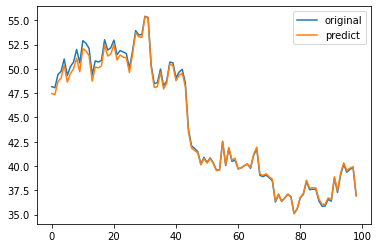

In [9]:
'''
用向量回归模型，从两个角度实现
从综合三个股票相关关系的角度，用同一时间三个股票价格作为向量
从各自角度出发，用之前提取的序列特征代替单一的当前股价做向量回归，达到比ARIMA更充分的表达来减小MSE
可以看出var算法有明显的系统性滞后，这是因为所用的向量回归的原理是差一天的预测
事实证明多维的var算法预测快得多，得到的结果也更精确，证明三个股价之间是有相关关系并具备有效信息的
且能够发现
'''
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

data_var=[np.array(stock_data.iloc[:,i]) for i in range(1,4) ]
data=[]
for i in range(0,2100):#构造向量序列
    data.append([data_var[0][i],data_var[1][i],data_var[2][i]])
tmp=np.array(data[200:300])[:-1,0]
predict=[]

for i in range(200,300):
    model = VAR(data[i-200:i])
    #训练
    model_fit = model.fit()
    # 预测
    yhat = model_fit.forecast(model_fit.y, steps=1)#接下来几步的预测取值
    predict.append(yhat[0][0])
predict=predict[1:]
comp = pd.DataFrame()
comp['original'] = tmp
comp['predict'] = np.array(predict)
comp.plot()
print(mean_squared_error(tmp,predict))
#可以改变并增添更多的特征提取：加入一定时间内的最大/最小值，均值，偏度和峰度作为所取特征

2.3 HWES预测（适合这种有趋势性的数据）

  0%|          | 0/100 [00:00<?, ?it/s]D:\anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 163.96it/s]


0.009468657740469594


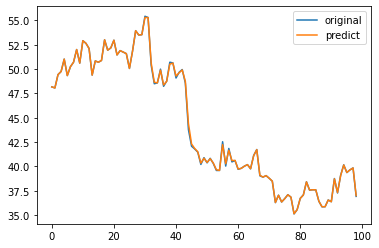

In [10]:
#hwes和var相似，都是基于当前的结果预测下一个结果，会有一位的偏移需要修正,很快，效果也很离谱
#python 切片取法[x:y]也是从x到y-1的左闭右开
from statsmodels.tsa.holtwinters import ExponentialSmoothing
data_ses=stock_data['TWTR']
predict=[]
for i in tqdm(range(200,300)):
    model_fit = ExponentialSmoothing(data_ses[i-200:i]).fit()
    #训练和预测
    yhat = model_fit.predict(201)
    predict.append(yhat)
predict=predict[1:]
tmp=np.array(data_ses[200:300])[:-1]
comp = pd.DataFrame()
comp['original'] = tmp
comp['predict'] =np.array(predict)
comp.plot()
print(mean_squared_error(tmp,predict))
#也许可以考虑季节性、趋势性对股票预测MSE的影响

2.4 总结和比较  
从运行时间来看，ARIMA训练时间较长，而var和hwes都有比较好的效率  
从预测准确率来看，ARIMA和var的MSE数量级相当，在可接受范围内，且能够正确预测趋势(前者相对好一点），而吸引人的是hwes的MSE在数量级上小得多，从中能看出三重指数平滑中指数线性加权相比线性回归在预测准确率上的优势

### 三、决策方式
3.1特征提取后进行LR逻辑回归预测极值点  
构造特征数据两个方案。传统方案：选取最后20，10，7，5天内数据梯度和5近邻分段平均值，加上最后五十个数据的峰度和偏度作为特征向量逻辑回归  
主成分分解（谱分解）方案:选取最主要的六个主成分取值作为特征向量做回归  
构造标签集两个方案：根据和周围数据的相对大小比较;直接调用signal.argrelextrema获取极值点。后者较为严格，容易错过机会，前者容易降低准确率  
利用LR模型做分别是/不是极大/极小值点的二分类

In [11]:
from sklearn.linear_model import LogisticRegression
import scipy.signal as signal
from sklearn.linear_model import LinearRegression

'''
LinearRegression回归序列梯度提取特征，加上原序列本身取部分值，用MaxMinNormalization标准化（归一化）得到特征集
对数据跑signal.argrelextrema判断是否是极大/极小得到二分类标签集
注：这里引入更多参数丰富特征也许能得到更好的效果

'''
#机器学习方法
data=pd.DataFrame(stock_data['TWTR'])
Y=np.array(data[4:2200])
#plt.figure(figsize=(16,4))
#plt.plot(np.arange(len(Y)),Y)
'''
#这里能有两组得到标签集的方法   标签集供学习
#1、直接通过定义极值得到标签集（专家系统）
#如果使用这个就需要在下面less_peak和greater_peak加上[0]
less_peak=signal.argrelextrema(Y,np.less_equal,order=3)
plt.plot(less_peak[0],Y[less_peak],'o')
greater_peak=signal.argrelextrema(Y,np.greater_equal,order=3)
plt.plot(greater_peak[0],Y[greater_peak],'+')
'''
data_array=[[i] for item in Y for i in item]
array_data=[i for item in Y for i in item]
tlen=5
tshe=7
#2、通过比较周围一定范围内更大/更小个数标记极值点
less_peak=[]
for i in range(20,2100):
    count=0
    for j in range(i-tlen,i+tlen):
        if array_data[i]<array_data[j]:
            count+=1
    if count>=tshe:
        less_peak.append(i)
            
greater_peak=[]
for i in range(20,2100):
    count=0
    for j in range(i-tlen,i+tlen):
        if array_data[i]>array_data[j]:
            count+=1
    if count>=tshe:
        greater_peak.append(i)

#线性回归或者SVM扩增序列特征（谱分解得到特征）也许能得到更好的结果
#先试试线性回归
#print(array_data)
def linearReg(size):
    tmp=[]
    for i in range(20,2100):
        a=[j for j in range(0,size)]
        b=data_array[i-size:i]
        c=LinearRegression().fit(b,a).coef_
        tmp.append(list(c))#啊啊要用list转出来，不然没法变成数组
    tmp=[k for item in tmp for k in item]
    return tmp
#print(LinearRegression().fit(X,Y).coef_)
linear_3=linearReg(3)
#print(linear_3)
linear_5=linearReg(5)
linear_10=linearReg(10)
linear_20=linearReg(20)
total_feature=[]
#主要步骤：取最后一段的梯度和当前值作为特征，实际上可以引入平均值和熵值等，比较效果
for i in range(0,2080):
    feature=[array_data[i+20],linear_3[i],linear_5[i],linear_10[i],linear_20[i]]
    #加入此前分段均值（时间序列的分段特征/分词）
    for i in range(0,5):
        x=np.mean(array_data[i-4*i-5+20:i-4*i+20])
        feature.append(x) 
    total_feature.append(feature)
def MaxMinNormalization(a):
    Min=np.min(a)
    Max=np.max(a)
    b=[]
    for t in a:
        t = (t - Min) / (Max - Min)
        b.append(t)
    return b
#total_feature=np.array(total_feature)

#for i in range(0,5):
    #total_feature[:,i]=MaxMinNormalization(total_feature[:,i])
#print(train_feature)
#制作标签集
total_Y=Y[20:2200]
total_less_labels=np.ones(2080)    #非极小值点类标签为1
for i in less_peak:
    if i>10 and i<2080:
        total_less_labels[i-20]=0 #极小点标签为0
total_greater_labels=np.ones(2080)    #非极大值点类标签为1
for i in greater_peak:
    if i>10 and i<2080:
        total_greater_labels[i-20]=0 #极小点标签为0




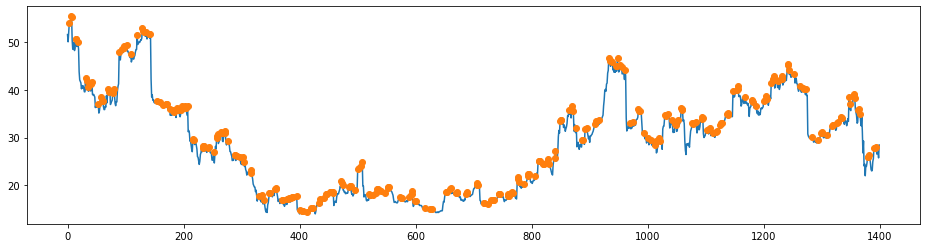

In [12]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
#train_feature,test_feature,train_less_labels,test_labels=train_test_split(total_feature,total_less_labels)
train_t1=200
train_t2=1600
test_t1=1600
test_t2=1800
train_feature=total_feature[train_t1:train_t2]
train_less_labels=total_less_labels[train_t1:train_t2]
test_feature=total_feature[test_t1:test_t2]
test_less_labels=total_less_labels[test_t1:test_t2]
train_greater_labels=total_greater_labels[train_t1:train_t2]
test_greater_labels=total_less_labels[test_t1:test_t2]
#print(train_greater_labels)
x_index=[i+train_t1 for i in range(0,train_t2-train_t1) if train_greater_labels[i]==0]
x_index1=[i for i in range(0,train_t2-train_t1) if train_greater_labels[i]==0]
plt.figure(figsize=(16,4))
plt.plot(range(0,train_t2-train_t1),total_Y[train_t1:train_t2])
plt.plot(x_index1,total_Y[x_index],'o')

[0. 0. 1. ... 1. 0. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


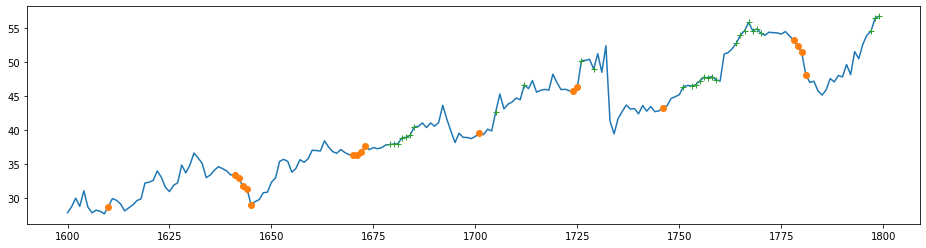

In [13]:
'''
用训练集训练LogisticRegression模型，为增加划分效率多进行有效投资，显式赋予特定权值
最后针对测试集每个位置预测是否是极值点，展现效果还是不错的
这里值得注意的是，由于训练集和数据集都只用到了每个数据点本身及以前的数据，不涉及后面的数据，所以对于动态序列（实际股票交易环境）来说
和这个模型是类似的，这个模型的预测可以看成是动态的对最后一天的预测
'''
print(train_less_labels)
clf_buy = LogisticRegression(class_weight={0:0.75,1:0.25}).fit(train_feature,train_less_labels)  #建立预测极值点模型 ,只用一维肯定是不靠谱的，只是根据绝对值取分类，必须特征维数序列扩增
clf_sell=LogisticRegression(class_weight={0:0.65,1:0.35}).fit(train_feature,train_greater_labels)
plt.figure(figsize=(16,4))
#print(train_labels)
plt.plot(np.arange(len(total_Y[test_t1:test_t2]))+test_t1,total_Y[test_t1:test_t2])
buy_point=clf_buy.predict(test_feature)
print(buy_point)
#buy_point=[int(i)for i in buy_point]
sell_point=clf_sell.predict(test_feature)
sell_point=[int(i)for i in sell_point]
buy_index=[i+test_t1 for i in range(0,len(buy_point)) if buy_point[i]==0]
sell_index=[i+test_t1 for i in range(0,len(sell_point)) if sell_point[i]==0]
#画出预测到的极大/极小值点作为买入/卖出点结果，黄色的o是买入点,绿色的+是卖出点
plt.plot(buy_index,total_Y[buy_index],'o')
plt.plot(sell_index,total_Y[sell_index],'+')
#less_peak1=signal.argrelextrema(np.array(test_feature),np.less_equal,order=3)
#print(less_peak1)
#less_peak1=[i+test_t1 for i in range(0,len(test_labels)) if test_labels[i]==0]
#plt.plot(less_peak1,total_Y[less_peak1],'+')

可以看出...嗯，结果差强人意吧，大多数时候能预测到一个挣钱序列

3.2 添加更多的特征来增强上述LR算法的判断准确率

In [14]:
# 序列 近似熵，用作序列特征
def ApEn(time_series, m=2, r=0.15):
    time_series = np.squeeze(time_series) 
    def max_dist(i, j):
        return max([abs(ix - jx) for ix, jx in zip(i, j)])
    def pi(m):
        x = [[time_series[j] for j in range(i, i + m - 1 + 1)]
             for i in range(N - m + 1)]
        C = [ len([1 for j in x if max_dist(i, j) <= r]) / (N - m + 1.0)  for i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(time_series)
    return pi(m) - pi(m + 1)
data_ap=np.array(stock_data['TWTR'])[200:600]
print(ApEn(data_ap))

0.24795009589039196


In [15]:
#样本熵，作为另一个序列特征，刚好有库可以调用
from sampen import sampen2

data_ap=np.array(stock_data['TWTR'])[0:80]
sampen_of_series = sampen2(data_ap)
print(sampen_of_series)
print(sampen_of_series[2][1])#样本熵取值
'''
实际上可以做成分分析看所有特征中哪个是主要内容，并用主要因素来训练极值点识别
'''

[(0, 4.208179704870899, 0.0021533164858487264), (1, 3.1135153092103742, 0.051191563090877024), (2, 0.6931471805599453, 0.3535533905932738)]
0.6931471805599453


'\n实际上可以做成分分析看所有特征中哪个是主要内容，并用主要因素来训练极值点识别\n'

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of

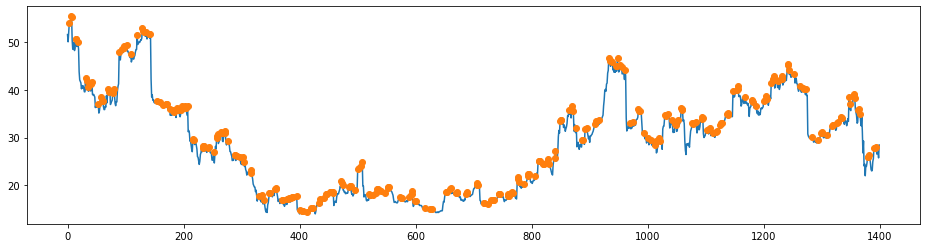

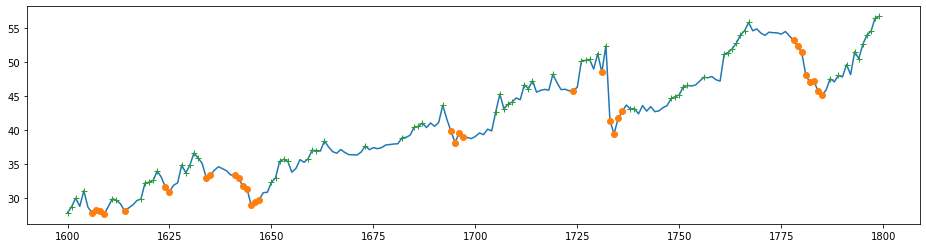

In [16]:
from sklearn.linear_model import LogisticRegression
import scipy.signal as signal
from sklearn.linear_model import LinearRegression
from sampen import sampen2

'''
LinearRegression回归序列梯度提取特征，加上原序列本身取部分值，用MaxMinNormalization标准化（归一化）得到特征集
对数据跑signal.argrelextrema判断是否是极大/极小得到二分类标签集
注：这里引入更多参数丰富特征也许能得到更好的效果

'''
#机器学习方法
data=pd.DataFrame(stock_data['TWTR'])
Y=np.array(data[4:2200])
#plt.figure(figsize=(16,4))
#plt.plot(np.arange(len(Y)),Y)
'''
#这里能有两组得到标签集的方法   标签集供学习
#1、直接通过定义极值得到标签集（专家系统）
#如果使用这个就需要在下面less_peak和greater_peak加上[0]
less_peak=signal.argrelextrema(Y,np.less_equal,order=3)
plt.plot(less_peak[0],Y[less_peak],'o')
greater_peak=signal.argrelextrema(Y,np.greater_equal,order=3)
plt.plot(greater_peak[0],Y[greater_peak],'+')
'''
data_array=[[i] for item in Y for i in item]
array_data=[i for item in Y for i in item]
tlen=5
tshe=7
#2、通过比较周围一定范围内更大/更小个数标记极值点
less_peak=[]
for i in range(20,2100):
    count=0
    for j in range(i-tlen,i+tlen):
        if array_data[i]<array_data[j]:
            count+=1
    if count>=tshe:
        less_peak.append(i)
            
greater_peak=[]
for i in range(20,2100):
    count=0
    for j in range(i-tlen,i+tlen):
        if array_data[i]>array_data[j]:
            count+=1
    if count>=tshe:
        greater_peak.append(i)

#线性回归或者SVM扩增序列特征（谱分解得到特征）也许能得到更好的结果
#先试试线性回归
#print(array_data)
def linearReg(size):
    tmp=[]
    for i in range(20,2100):
        a=[j for j in range(0,size)]
        b=data_array[i-size:i]
        c=LinearRegression().fit(b,a).coef_
        tmp.append(list(c))#啊啊要用list转出来，不然没法变成数组
    tmp=[k for item in tmp for k in item]
    return tmp

def ApEn(time_series, m=2, r=0.15):
    time_series = np.squeeze(time_series) 
    def max_dist(x_i, x_j):
        return max([abs(ia - ja) for ia, ja in zip(x_i, x_j)])
    def phi(m):
        x = [[time_series[j] for j in range(i, i + m - 1 + 1)]
             for i in range(N - m + 1)]
        C = [ len([1 for x_j in x if max_dist(x_i, x_j) <= r]) / (N - m + 1.0)  for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(time_series)
    return phi(m) - phi(m + 1)

def sampEn(data_ap):
    sampen_of_series = sampen2(data_ap)
    return sampen_of_series[2][1]

#print(LinearRegression().fit(X,Y).coef_)
linear_3=linearReg(3)
#print(linear_3)
linear_5=linearReg(5)
linear_10=linearReg(10)
linear_20=linearReg(20)
total_feature=[]
#主要步骤：取最后一段的梯度和当前值作为特征，实际上可以引入平均值和熵值等，比较效果
for i in range(0,2080):
    feature=[array_data[i+20],linear_3[i],linear_5[i],linear_10[i],linear_20[i]]
    #加入此前分段均值（时间序列的分段特征/分词）
    for j in range(0,5):
        x=np.mean(array_data[i-4*j-5+20:i-4*j+20])
        feature.append(x) 
    #优化：加入熵值作为特征
    feature.append(ApEn(array_data[i:i+20]))
    #feature.append(sampEn(np.array(array_data)[i-60:i+20]))
    total_feature.append(feature)
    #print(total_feature)
def MaxMinNormalization(a):
    Min=np.min(a)
    Max=np.max(a)
    b=[]
    for t in a:
        t = (t - Min) / (Max - Min)
        b.append(t)
    return b
#total_feature=np.array(total_feature)
#这里可以选择进行归一化，不过归一化后不容易收敛，所以暂时不用
#for i in range(0,5):
    #total_feature[:,i]=MaxMinNormalization(total_feature[:,i])
#print(train_feature)
#制作标签集
total_Y=Y[20:2200]
total_less_labels=np.ones(2080)    #极大点标签为1
for i in less_peak:
    if i>10 and i<2080:
        total_less_labels[i-20]=0 #极小点标签为0
total_greater_labels=np.ones(2080)    #极大点标签为1
for i in greater_peak:
    if i>10 and i<2080:
        total_greater_labels[i-20]=0 #极小点标签为0

#划分训练集和测试集
from sklearn.model_selection import train_test_split
#train_feature,test_feature,train_less_labels,test_labels=train_test_split(total_feature,total_less_labels)
train_t1=200
train_t2=1600
test_t1=1600
test_t2=1800
train_feature=total_feature[train_t1:train_t2]
train_less_labels=total_less_labels[train_t1:train_t2]
test_feature=total_feature[test_t1:test_t2]
test_less_labels=total_less_labels[test_t1:test_t2]
train_greater_labels=total_greater_labels[train_t1:train_t2]
test_greater_labels=total_less_labels[test_t1:test_t2]
#print(train_greater_labels)
x_index=[i+train_t1 for i in range(0,train_t2-train_t1) if train_greater_labels[i]==0]
x_index1=[i for i in range(0,train_t2-train_t1) if train_greater_labels[i]==0]
plt.figure(figsize=(16,4))
plt.plot(range(0,train_t2-train_t1),total_Y[train_t1:train_t2])
plt.plot(x_index1,total_Y[x_index],'o')
clf_buy = LogisticRegression(class_weight={0:0.7,1:0.3}).fit(train_feature,train_less_labels)  #建立预测极值点模型 ,只用一维肯定是不靠谱的，只是根据绝对值取分类，必须特征维数序列扩增
clf_sell=LogisticRegression(class_weight={0:0.6,1:0.4}).fit(train_feature,train_greater_labels)
plt.figure(figsize=(16,4))
#print(train_labels)
plt.plot(np.arange(len(total_Y[test_t1:test_t2]))+test_t1,total_Y[test_t1:test_t2])
buy_point=clf_buy.predict(test_feature)
#buy_point=[int(i)for i in buy_point]
sell_point=clf_sell.predict(test_feature)
sell_point=[int(i)for i in sell_point]
buy_index=[i+test_t1 for i in range(0,len(buy_point)) if buy_point[i]==0]
sell_index=[i+test_t1 for i in range(0,len(sell_point)) if sell_point[i]==0]
#画出最后的预测结果
plt.plot(buy_index,total_Y[buy_index],'o')
plt.plot(sell_index,total_Y[sell_index],'+')

嗯...加入熵特征后预测的极值点更明确，也更多地捕获了机会点，不过较松的判断回归也增加了风险

 3.3 动态时间规整
针对盈利窗口进行简陋的模式识别，这主要是针对40次交易区间内的严格短线交易机会

In [17]:
'''
动态时间规整方法（简陋的窗口模式识别方法）
不需要稳定序列，可以直接比较序列
主要衡量和当前阶段比对相似的短期窗口是否盈利，实现炒短线的效果（大约8天内的结果）
具体来说，就是在序列窗口结尾买入，经过hold时间后卖出
缺点：用时较长
'''
KO_data=stock_data['TWTR']
tlen = 10
hold = 40
thre = 8
tseries = []
for i in range(tlen,len(KO_data)-hold-1,tlen):
    #每日收益（率）
    pct = KO_data.iloc[i-tlen:i].pct_change()[1:].values*100    
    #阶段总收益（率）
    res = (KO_data[i+hold+1] -KO_data[i])/KO_data[i] * 100     
    tseries.append((pct,res))
#print(tseries)


In [18]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import math
from tqdm import tqdm

#计算两个序列的相似度距离
def pair_distance(x, y):
    distance, path = fastdtw(x, y, dist=euclidean)
    return distance

dist_pairs = []
for i in tqdm(range(len(tseries))):
    for j in range(len(tseries)):
        dist = pair_distance(tseries[i][0],tseries[j][0])
        #存储两个相似序列序列号码，距离，序列收益
        dist_pairs.append((i,j,dist,tseries[i][1],tseries[j][1]))
        
#得到结果各列分别是两个序列序号，两个序列相似度和两个序列总收益
dist_frame = pd.DataFrame(dist_pairs,columns=['A','B','Dist','A Ret','B Ret'])
sf = dist_frame[dist_frame['Dist']>0].sort_values(['A','B']).reset_index(drop=1)
#筛选出相似度高的
sfe = sf[sf['A']+math.ceil(float(tlen+hold)/tlen) <= sf['B']]
winf = sfe[(sfe['Dist']<=thre)&(sfe['A Ret']>0)]
print(winf)


100%|██████████| 209/209 [01:19<00:00,  2.62it/s]

         A    B      Dist      A Ret      B Ret
3574    17   39  7.961376  33.324698 -17.493038
3614    17   79  6.766691  33.324698 -11.852699
3667    17  132  7.248403  33.324698  25.417853
3677    17  142  6.612057  33.324698  13.076923
3685    17  150  7.573428  33.324698  13.769364
...    ...  ...       ...        ...        ...
31601  151  194  7.558428  13.763001  -8.536041
32223  154  192  7.748468   2.827283 -10.864588
35341  169  190  7.210903  23.417380   8.561983
35536  170  177  6.176080  23.995068  14.207995
35550  170  191  6.610150  23.995068  -5.814809

[103 rows x 5 columns]


In [19]:
excluded = {}
return_list = []
choose_list=[]
#检查根据经验得到的序列判断
def get_returns(r):
    if excluded.get(r['A']) is None:
        return_list.append(r['B Ret'])
        choose_list.append(r['B'])
        #“错误经验”如果导致损失，那么删除代表错误经验的对于经验序列
        if r['B Ret']<0:
            excluded.update({r['A']:1})
#模拟交易，看获利交易数量比例
def show_res(s,n=252):
    cnt = len(s)
    wins = len(s[s>0])
    losses = len(s[s<0])
    mean = round(s.mean(),3)
    print('Trades:',cnt,'\nWins:',wins,'\nLosses:',losses,'\nMean:',mean,)

winf.apply(get_returns,axis=1)
#print(return_list)
print(choose_list)
show_res(pd.Series(return_list))


[39.0, 35.0, 88.0, 140.0, 94.0, 132.0, 197.0, 97.0, 150.0, 151.0, 195.0, 94.0, 136.0, 150.0, 151.0, 152.0, 195.0, 94.0, 95.0, 96.0, 135.0, 136.0, 151.0, 152.0, 154.0, 155.0, 136.0, 151.0, 154.0, 169.0, 201.0, 104.0, 125.0, 101.0, 155.0, 150.0, 206.0, 142.0, 151.0, 196.0, 187.0, 136.0, 152.0, 155.0, 142.0, 204.0, 196.0, 155.0, 196.0, 150.0, 151.0, 152.0, 154.0, 155.0, 197.0, 154.0, 186.0, 195.0, 169.0, 179.0, 194.0, 192.0, 190.0, 177.0, 191.0]
Trades: 65 
Wins: 46 
Losses: 19 
Mean: 4.184


[390.0, 350.0, 880.0, 1400.0, 940.0, 1320.0, 1970.0, 970.0, 1500.0, 1510.0, 1950.0, 940.0, 1360.0, 1500.0, 1510.0, 1520.0, 1950.0, 940.0, 950.0, 960.0, 1350.0, 1360.0, 1510.0, 1520.0, 1540.0, 1550.0, 1360.0, 1510.0, 1540.0, 1690.0, 2010.0, 1040.0, 1250.0, 1010.0, 1550.0, 1500.0, 2060.0, 1420.0, 1510.0, 1960.0, 1870.0, 1360.0, 1520.0, 1550.0, 1420.0, 2040.0, 1960.0, 1550.0, 1960.0, 1500.0, 1510.0, 1520.0, 1540.0, 1550.0, 1970.0, 1540.0, 1860.0, 1950.0, 1690.0, 1790.0, 1940.0, 1920.0, 1900.0, 1770.0, 1910.0]


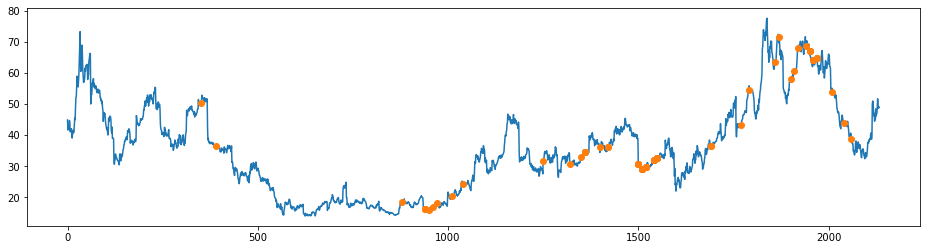

In [20]:
#画图看看对短线机会的捕捉能力
plt.figure(figsize=(16,4))
plt.plot(np.arange(len(KO_data)),KO_data)
choose_list1=[i*tlen for i in choose_list]
print(choose_list1)
plt.plot(choose_list1,KO_data[choose_list1],'o')

### 四、简单的决策方式和另外做的一些附录

4.1 三支股票之间的关系探究  
4.1.1 皮尔逊相关关系

'\n主要结论\n1、从中我们能看出在不同时段序列两两之间正负相关关系有较大波动，大多数是由于某个特定股票价格因为自身内部因素剧烈变化，对其他股票价格不具\n有指导意义。\n2、不过在大多数时候相关关系还是比较强的，这和市场整体的表现有关系\n3、比较有意思的是TWTR-KO，TWTR-GM序列Pearson r 在1000数据左右区段更为相似，但体现出一定的滞后关系，这可能是因为和GM通用汽车作为高级\n消费品相比KO生活必需品受到市场消费者信心影响更快。\n3、GM-KO，TWTR-GM序列相关性在1000以后几乎同步变化，比较好地反映了市场的整体面貌，这一点也许在进一步的价格预测中能够有作用\n'

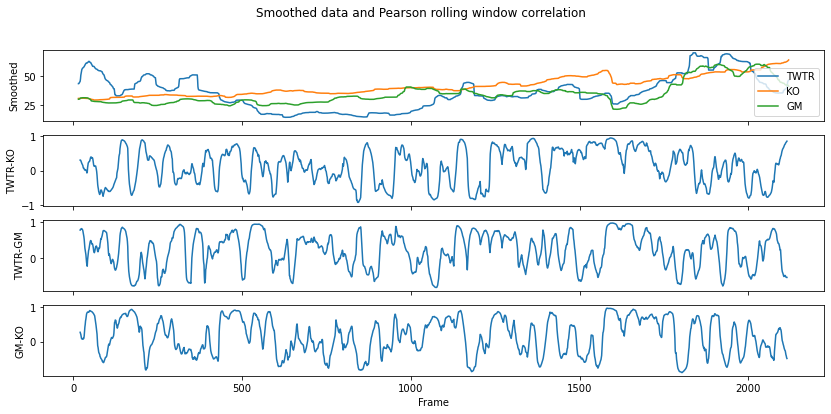

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
 
df = stock_data
overall_pearson_r = df.corr().iloc[0,1]
r_window_size = 40#窗口宽度
df_interpolated = df.interpolate()
# 计算滑动窗口同步性
rolling_r1 = df_interpolated['TWTR'].rolling(window=r_window_size, center=True).corr(df_interpolated['KO'])
rolling_r2 = df_interpolated['TWTR'].rolling(window=r_window_size, center=True).corr(df_interpolated['GM'])
rolling_r3 = df_interpolated['GM'].rolling(window=r_window_size, center=True).corr(df_interpolated['KO'])
f,ax=plt.subplots(4,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
#分别绘制两两之间的关系曲线，1代表正相关，-1负相关，0不相干
ax[0].set(xlabel='Frame',ylabel='Smoothed')
rolling_r1.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='TWTR-KO')
rolling_r2.plot(ax=ax[2])
ax[2].set(xlabel='Frame',ylabel='TWTR-GM')
rolling_r3.plot(ax=ax[3])
ax[3].set(xlabel='Frame',ylabel='GM-KO')
plt.suptitle("Smoothed data and Pearson rolling window correlation")
'''
主要结论
1、从中我们能看出在不同时段序列两两之间正负相关关系有较大波动，大多数是由于某个特定股票价格因为自身内部因素剧烈变化，对其他股票价格不具
有指导意义。
2、不过在大多数时候相关关系还是比较强的，这和市场整体的表现有关系
3、比较有意思的是TWTR-KO，TWTR-GM序列Pearson r 在1000数据左右区段更为相似，但体现出一定的滞后关系，这可能是因为和GM通用汽车作为高级
消费品相比KO生活必需品受到市场消费者信心影响更快。
3、GM-KO，TWTR-GM序列相关性在1000以后几乎同步变化，比较好地反映了市场的整体面貌，这一点也许在进一步的价格预测中能够有作用
'''

4.1.2 时间滞后互相关WTLCC  
针对3.1.1中间接观测到的KO-GM模式相位差，并从图上可以看到KO和GM的一些相似性，所以用WTLCC来看看先后关系（另外主要这个能画出有意思的关系热力图x）

D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\anaconda\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


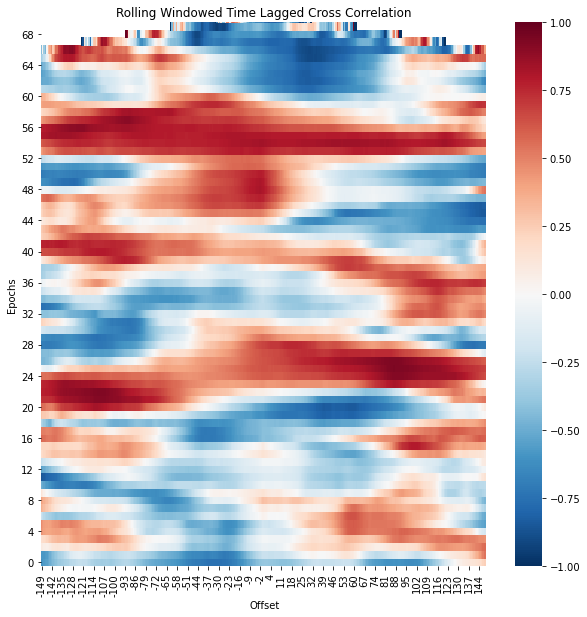

In [22]:
#假设条件：两个序列中探究的事件同时发生，同时每个模式相近
#互相关函数
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

# 滑动窗口时间滞后互相关
seconds = 5
fps = 30
window_size = 300 #样本
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['GM'].iloc[t_start:t_end]
    d2 = df['KO'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)
 
 
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',ylim=[0,70],xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()])
plt.show()